In [72]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import StratifiedShuffleSplit
from matplotlib import pyplot as plt
from PIL import Image
from collections import Counter
import pickle
from os import path
import util

# __Improving Model Performance with Batch-Normalization and Data Augmentation__

## __Abstract__
***

With thousands of trainable parameters, deep neural networks are prone to overfitting the training set. Regularization restricts the freedom of the model. Consequently, this causes the model to less likely fit the noise of the training data and improve its ability to generalize. In this notebook, we show that two types of reguralization techniques improve the performance of a learning model. In particular, we will build a __multiclass image classifier__ implemented with __data augmentation__ and __batch normalization__. Our model is made up of convolutional, max pooling, flatten, and dense layers arranged as follows:

<img src="img/model.png" style="width:200px;height:500px">

We will make use of the CIFAR-10 dataset collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton from the University of Toronto. Without data augmentation and batch normalization, our baseline model a validation accuracy of around $70\%$. With the mentioned regularization techniques, our model achieves $85\%$ accuracy on our test set. 

Author: Faerlin Pulido <br>
GitHub: https://github.com/faerlinpulido/

## __Data__
***

__Name__: CIFAR-10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html) <br>
__Data__: $32 \times 32 \times 3$ RGB images distributed over 10 classes <br>
__Classes__: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck <br>

We begin by fetching CIFAR-10 dataset using <code>tf.keras.datasets.cifar10.load_data()</code>. It is made up of 60000 RGB images of size $32\times32\times3$. The dataset is equally distributed over 10 classes and are mutually exclusive. That is, there are 6000 images per class and each image only belongs to one class. Below, we divide the dataset into a training set and a test set of size 50000 and 10000, respectively.

In [65]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (50000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3)


The i-th image <code>x_train[i]</code> belongs to the class <code>y_train[i]</code>. This also applies to <code>x_test</code> and <code>y_test</code>. In other words, the arrays <code>y_train</code> and <code>y_test</code> contain the target labels for the images in <code>x_train</code> and <code>x_test</code>. Next, let's confirm that there are indeed 10 classes in our training set where each class has 5000 images. We achive this by using the <code>collections.Counter()</code> method. 

In [66]:
temp = [label[0] for label in y_train]
counter = Counter(temp)
number_of_classes = len(counter)
for i in range(number_of_classes):
    print('Class %d has %d instances in the training set' % (i, counter[i]))

Class 0 has 5000 instances in the training set
Class 1 has 5000 instances in the training set
Class 2 has 5000 instances in the training set
Class 3 has 5000 instances in the training set
Class 4 has 5000 instances in the training set
Class 5 has 5000 instances in the training set
Class 6 has 5000 instances in the training set
Class 7 has 5000 instances in the training set
Class 8 has 5000 instances in the training set
Class 9 has 5000 instances in the training set


To get a quick feel of our data, let's plot 30 images from the training set. 

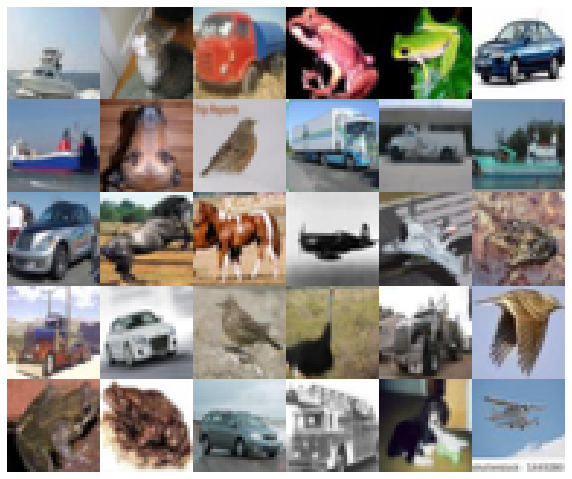

In [67]:
example_images = np.r_[x_train[100:130]]
util.plot_image(example_images, images_per_row=6)
plt.show()

## __Preprocessing Steps__
***

We apply the following preprocessing steps to our dataset:
- Normalize the dataset
- Create a validation set
- One-Hot encode the target labels

### __Normalize the dataset__

Each RGB channel uses 8-bits to encode pixel values. Therefore, we can normalize the pixel values by dividing it by 255. 

In [68]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

### __Create a Validation Set__

In the sections that follow, we will be building various models. Because we have a balanced dataset, we can use __accuracy__ as the metric to asses the performance of these models. We will compare these models base on their performance on a validation set, which we will create out of the training set. 

In [69]:
# Get the indices from Stratified Sampling
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
generator = splitter.split(x_train, y_train)
train_index, val_index = next(generator)

# Get the Stratified training and validation set
strat_x_train = x_train[train_index]
strat_y_train = y_train[train_index]
strat_x_val = x_train[val_index]
strat_y_val = y_train[val_index]

# Rename to x_train, y_train, x_val, y_val
x_train = strat_x_train
y_train = strat_y_train
x_val = strat_x_val
y_val = strat_y_val

### __One-Hot Encode the Target Labels__ 

Using <code>tf.keras.utils.to_categorical</code> we encode the target labels to one-hot vectors where class <code>k</code> is encoded as a vector of size 10 and the k-th index is 1 and the remaining entries are 0's. 

In [70]:
number_of_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, number_of_classes)
y_valid = tf.keras.utils.to_categorical(y_valid, number_of_classes)
y_test = tf.keras.utils.to_categorical(y_test, number_of_classes)

## __Model Training__
***

### __Baseline Model__
The purpose of this notebook is to show that regularization techniques such as batch normalization and data augmentation can improve model performance. To this end, we will first build a baseline model. This __baseline model__ will consists of _convolutional_, _max pooling_ and _flatten layers_ with an output _dense_ layer that uses a softmax activation: 

<img src="img/baseline.png" style="width:200px;height:450px">

Below, we will create a class that implements this baseline model, which we will call <code>MyModel</code>.

In [71]:
class MyModel(tf.keras.Model):
    '''Our baseline model'''
    
    def __init__(self, input_shape, number_of_classes):
        
        super(MyModel, self).__init__()
        self.conv2d_A1 = Conv2D(32, (3,3), padding='same', activation='elu', input_shape=input_shape)
        self.conv2d_A2 = Conv2D(32, (3,3), padding='same', activation='elu')
        self.maxpool2d_A3 = MaxPooling2D(pool_size=(2,2))
        self.conv2d_B1 = Conv2D(64, (3,3), padding='same', activation='elu')
        self.conv2d_B2 = Conv2D(64, (3,3), padding='same', activation='elu')
        self.maxpool2d_B3 = MaxPooling2D(pool_size=(2,2))
        self.conv2d_C1 = Conv2D(128, (3,3), padding='same', activation='elu')
        self.conv2d_C2 = Conv2D(128, (3,3), padding='same', activation='elu')
        self.maxpool2d_C3 = MaxPooling2D(pool_size=(2,2))
        self.flatten = Flatten()
        self.out = Dense(number_of_classes, activation='softmax')
    
    def call(self, x):
        x = self.conv2d_A1(x)
        x = self.conv2d_A2(x)
        x = self.maxpool2d_A3(x)
        x = self.conv2d_B1(x)
        x = self.conv2d_B2(x)
        x = self.maxpool2d_B3(x)
        x = self.conv2d_C1(x)
        x = self.conv2d_C2(x)
        x = self.maxpool2d_C3(x)
        x = self.flatten(x)
        x = self.out(x)
        return x

In [84]:
# Initialize and compile model
input_shape = x_train[1:]
model = MyModel(input_shape, number_of_classes)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train Model
filename = 'history/history_model_base'
if not path.exists(filename):
    # Fit and save model
    history = model.fit(x_train, y_train, validation_data=(x_valid,y_valid), batch_size=32, epochs=40) 
    with open(filename, 'wb') as file:
        pickle.dump(history.history, file)
    history_base = history.history
else:
    # Load model
    with open(filename, 'rb') as file:
        history_base = pickle.load(file)

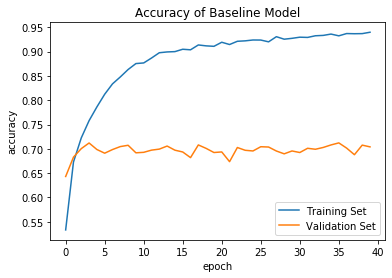

In [92]:
# Plot training and validation accuracy
plt.plot(history_base['accuracy'])
plt.plot(history_base['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy of Baseline Model')
plt.legend(['Training Set', 'Validation Set'], loc='lower right');

From the plot above, we observe that our baseline model is overfitting the training set. After 5 epochs, our model no longer improves its performance on the validation set. 

### __Model with Data Augmentation__

To overcome overfitting and help the model learn and generalize, we will apply real-time data augmentation. We will wrap our training set using <code>ImageDataGenerator</code> object. This will apply various transformation to our training images such as:
- horizontal flips
- height shifts
- width shifts
- rotation

In [93]:
datagen = ImageDataGenerator(rotation_range=10,     # randomly rotate images in the range 0 to 10 
                             width_shift_range=0.1, # randomly shift images horizontally (fraction of total width)
                             height_shift_range=0.1,# randomly shift images vertically (fraction of total height)
                             horizontal_flip=True)  # randomly flip images

In [94]:
# Create and compile model
model = MyModel(input_shape, number_of_classes)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

# Train Model
filename = 'history/history_model_with_data_augmentation'
if not path.exists(filename):
    # Fit and save model
    history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=32), validation_data=(x_valid,y_valid), epochs=40)
    with open(filename, 'wb') as file:
        pickle.dump(history.history, file)
    history_da = history.history
else:
    # Load model
    with open(filename, 'rb') as file:
        history_da = pickle.load(file)

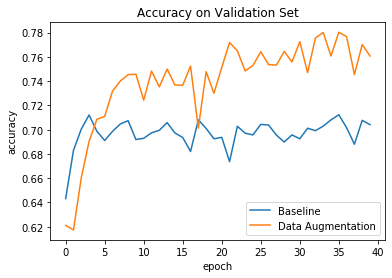

In [97]:
# Plot training and validation accuracy
plt.plot(history_base['val_accuracy'])
plt.plot(history_da['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy on Validation Set')
plt.legend(['Baseline', 'Data Augmentation'], loc='lower right');

With data augmentation, the accuracy of our model on the validation set improves from roughly $70\%$ (baseline) to $76\%$. 

### __Model with Batch Normalization__

Generally speaking, we want to normalize and standardize our input data as part of our preprocessing step. This is to prevent the variance of input from differing significantly with the variance of output for each layer. This reduces the likelihood of the vanishing/exploding gradients problem at the beginning of training. However, it doesn't guarantee that they won't come back during training. This is where __Batch Normalization__ comes in. The <code>tf.keras.layers.BatchNormalization</code> "maintains the mean and standard deviation of the activation of the previous layer close to 0 and 1, respectively. 

We will modify our baseline model as follows: add a batch-normalization layer after every layer with an activation function, with the exception of the final layer. We will call this modified model <code>MyModelBatchNorm</code>. 

In [99]:
class MyModelBatchNorm(tf.keras.Model):
    '''Model with Batch Normalization after all the layers with an activation function except the final layer.'''
    
    def __init__(self, input_shape, number_of_classes):
        
        super(MyModelBatchNorm, self).__init__()
        self.conv2d_A1 = Conv2D(32, (3,3), padding='same', activation='elu', input_shape=input_shape)
        self.batchNorm_A1 = BatchNormalization()
        self.conv2d_A2 = Conv2D(32, (3,3), padding='same', activation='elu')
        self.batchNorm_A2 = BatchNormalization()
        self.maxpool2d_A3 = MaxPooling2D(pool_size=(2,2))
        self.conv2d_B1 = Conv2D(64, (3,3), padding='same', activation='elu')
        self.batchNorm_B1 = BatchNormalization()
        self.conv2d_B2 = Conv2D(64, (3,3), padding='same', activation='elu')
        self.batchNorm_B2 = BatchNormalization()
        self.maxpool2d_B3 = MaxPooling2D(pool_size=(2,2))
        self.conv2d_C1 = Conv2D(128, (3,3), padding='same', activation='elu')
        self.batchNorm_C1 = BatchNormalization()
        self.conv2d_C2 = Conv2D(128, (3,3), padding='same', activation='elu')
        self.batchNorm_C2 = BatchNormalization()
        self.maxpool2d_C3 = MaxPooling2D(pool_size=(2,2))
        self.flatten = Flatten()
        self.out = Dense(number_of_classes, activation='softmax')
    
    def call(self, x):
        x = self.conv2d_A1(x)
        x = self.batchNorm_A1(x)
        x = self.conv2d_A2(x)
        x = self.batchNorm_A2(x)
        x = self.maxpool2d_A3(x)
        x = self.conv2d_B1(x)
        x = self.batchNorm_B1(x)
        x = self.conv2d_B2(x)
        x = self.batchNorm_B2(x)
        x = self.maxpool2d_B3(x)
        x = self.conv2d_C1(x)
        x = self.batchNorm_C1(x)
        x = self.conv2d_C2(x)
        x = self.batchNorm_C2(x)
        x = self.maxpool2d_C3(x)
        x = self.flatten(x)
        x = self.out(x)
        return x

In [100]:
# Create and compile model
model = MyModelBatchNorm(input_shape, number_of_classes)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

# Train Model
filename = 'history/history_model_with_data_augmentation_batch_normalization'
if not path.exists(filename):
    # Fit and save model
    history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=32), validation_data=(x_valid,y_valid), epochs=40)
    with open(filename, 'wb') as file:
        pickle.dump(history.history, file)
    history_dabn = history.history
else:
    # Load model
    with open(filename, 'rb') as file:
        history_dabn = pickle.load(file)

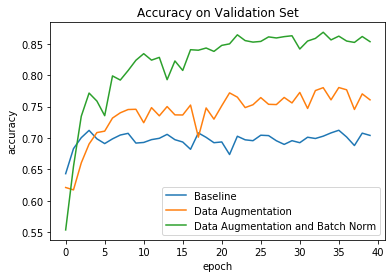

In [101]:
# Plot training and validation accuracy
plt.plot(history_base['val_accuracy'])
plt.plot(history_da['val_accuracy'])
plt.plot(history_dabn['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy on Validation Set')
plt.legend(['Baseline', 'Data Augmentation', 'Data Augmentation and Batch Norm'], loc='lower right');

With data augmentation and batch-normalization, the accuracy of our model on the validation set improves from roughly $70\%$ (baseline) to around $85\%$. 

## __Evaluate on Test Set__
***

Retrain <code>MyModelBatchNorm</code> for 20 epochs and evaluate it on the test set. 

In [102]:
model = MyModelBatchNorm(input_shape, number_of_classes)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.fit_generator(datagen.flow(x_train, y_train, batch_size=32), epochs=20)

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
1250/1250 [==============================] - 65s 52ms/step - loss: 1.5151 - accuracy: 0.4010
Epoch 2/20
1250/1250 [==============================] - 44s 35ms/step - loss: 1.0560 - accuracy: 0.6144
Epoch 3/20
1250/1250 [==============================] - 44s 35ms/step - loss: 0.8805 - accuracy: 0.6859
Epoch 4/20
1250/1250 [==============================] - 44s 35ms/step - loss: 0.7676 - accuracy: 0.7310
Epoch 5/20
1250/1250 [==============================] - 44s 36ms/step - loss: 0.6897 - accuracy: 0.7591
Epoch 6/20
1250/1250 [==============================] - 44s 35ms/step - loss: 0.6293 - accuracy: 0.7771
Epoch 7/20
1250/1250 [==============================] - 45s 36ms/step - loss: 0.5846 - accuracy: 0.7925
Epoch 8/20
1250/1250 [==============================] - 45s 36ms/step - loss: 0.5473 - accuracy: 0.8114
Epoch 9/20
1250/1250 [==============================] - 45s 36ms/step - loss: 0.5135 - accuracy: 0.8193
Epoch 10/20
1250/1250 [==============================] - 45s 36m

Our test accuracy is $84\%$. 

## __Conclusion__
***

Our final model includes two regularization techniques: data augmentation and batch-normalization. 

<img src="img/model.png" style="width:200px;height:500px">

The performance of the baseline model on the validation set is roughly $70\%$. With data augmentation and batch-normalization, our model improved its performance to around $85\%$. 